# table of contents
TODO

## RMC for exponential function
### Basic construction
We ran some tests for 
$y'=y, y(0)=1$ with a basic Monte Carlo recursive scheme to build understanding. <br>

To do Monte Carlo you need a random variable $Y(t)$ which you can simulate such that $y(t) = E[Y(t)]$. To construct such a random variable you first need to turn the ODE into an integral equation which is easier to manipulate in this context. There are multiple techniques to do that (we will write it down later) in this case we want a recursive integral equation for theoretical reasons. This is easily obtained by integrating both sides.

$$
y(t)= 1 + \int_0^t y(s)ds.
$$
Do the following substitution in the integral $ds = \frac{ds}{dU} dU$ with $U = \text{Uniform}(0,t)$. (https://en.wikipedia.org/wiki/Radon%E2%80%93Nikodym_theorem $U$ dominates $1_{[0,t]}$ you could interpret constants as random variables) Now you can write the integral as an expectation using reverse LOTUS (https://en.wikipedia.org/wiki/Law_of_the_unconscious_statistician).

$$
\begin{align*}
y(t)&= 1 + E[y(U) \frac{ds}{dU}]\\
&= 1 + tE[y(x) \mid U = x]\\
\end{align*}
$$
Suppose we can construct a family of random variables $Y(x)>0, 0<x<t$ (induction like) such that $y(x) = E[Y(x)]$. We will try to construct $Y(t)$ out of those. Sub this property in the previous equation.

$$
y(t)= 1 + tE[E[Y(x)] \mid U = x]
$$

Now merge the expectations (in this case it's ok because everything is positive).

$$
\begin{align*}
y(t)&= 1 + tE[Y(x) \mid U = x]\\
    &= 1 + tE[Y(U)]\\
    &= E[1 + tY(U)]
\end{align*}
$$
$1 + tY(U)$ is has the property of the random variable we wanted to construct. To complete the construction we would need
to construct $Y(x)>0, 0<x<\varepsilon$ for an arbitrary $\varepsilon$. We haven't figured out how to do that but we approximate such random variable for small $\varepsilon$ with $1$.<br>
Following code demonstrates how to construct $Y(t)$ approximately using recursion.

In [31]:
from random import random
def Y(t,eps):
    return 1 + t* Y(random()*t,eps) if t>eps else 1 

sol = 0
nsim = 10**3
eps = 0.01
t = 1

for _ in range(nsim):
    sol += Y(t,eps)/nsim

print(f"exp({t}) is approx = {sol}")

exp(1) is approx = 2.7599096369837333


For the Monte Carlo simulation to convergence we need $\text{Var}(Y(t)) < \infty$. (which we don't have results on yet)

### Modifications
Once we have a random variable where we can use Monte Carlo on there are tricks to manipulate that random variable such that the expectance is preserved but the behavior of the random variable changes. 

#### Russian Roulette
Russian Roulette is a popular technique in rendering (see Veach). The idea is accelerating simulation by "killing" low contribution simulations early but this has as side effect increased variance. This can be achieved mathematically by adding bernoulli processes without changing the expectance. <br> 

In previous example we can change the recursive definition slightly by replacing $t$ with bernoulli process $B(t)$ for $t<1$ (this doesn't affect the expectance). Then the code becomes:

In [169]:
from random import random
from math import exp
def Y(t):
    return (1 + Y(random()*t) if 1-t<random() else 1) if t<1 else 1 + t* Y(random()*t)

sol = 0
nsim = 10**4
t = 5

for _ in range(nsim):
    sol += Y(t)/nsim

percentage_error = (sol - exp(t))/exp(t)

print(f"exp({t}) is approx = {sol}")
print(f"%error = {percentage_error}")

exp(5) is approx = 145.87086638244105
%error = -0.017129833604434153


We don't need to approximate our random variable for $\varepsilon$ because the simulation gets stopped by killing. Russian Roulette in this case got rid of a parameter, made our random variable unbiased and accelerated the program! 

#### Control Variates
Control variates is a widely used method to reduce variance in Monte Carlo methods. The idea is to subtract a similar random variable and add a other random variable with the same expectance. Often the expectance is known and the other random variable becomes a constant. (maybe we add an analysis of variance later)<br>

Let's go back to our example. It's a bit tricky to find a control variate for the whole family of random variables because adding a control variate influences higher order recursion calls. The only thing that should stay the same is that $y(t)=E[Y(t)]$ if we had an approximation of $y(t) \approx u(t)$ we can use that as a control variate. Let's go with a constant approximation of our solution $1$ because of our initial condition and $1+x$ for testing the case when the the expectance isn't known and estimated by Monte Carlo with $1$ simulation. 

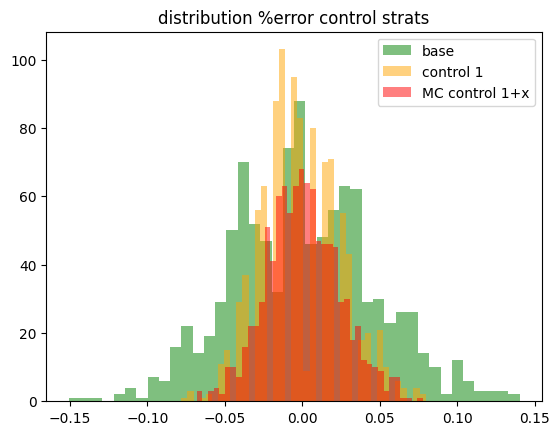

In [213]:
from random import random
from math import exp
import matplotlib.pyplot as plt

#Russian Roulette base
def Y(t):
    return (1 + Y(random()*t) if 1-t<random() else 1) if t<1 else 1 + t* Y(random()*t)

#Russian Roulette analytic control 1 
def Y1(t):
    return (1 + Y(random()*t)-1 + t if 1-t<random() else 1+t) if t<1 else 1 + t* (Y(random()*t)-1)+t

#Russian Roulette MC1 control 1+x 
def Y2(t):
    s = random()*t
    return (1 + Y(s)-1-s+ t*(1+random()*t) if 1-t<random() else 1+ t*(1+random()*t)) if t<1 else 1 + t* (Y(s)-1-s) + t*(1+random()*t)


nsim = 10**2
t = 0.5
sols = []
sols1 = []
sols2 = []

for _ in range(1000):
    sol = 0
    sol1 = 0
    sol2 = 0
    for _ in range(nsim):
        sol += Y(t)/nsim
        sol1 += Y1(t)/nsim
        sol2 += Y2(t)/nsim
    sols.append((sol - exp(t))/exp(t))
    sols1.append((sol1 - exp(t))/exp(t))
    sols2.append((sol2 - exp(t))/exp(t))
data = [sols,sols1,sols2]

plt.hist(sols,bins=40,alpha = 0.5, color = "green",label="base")
plt.hist(sols1,bins =40,alpha = 0.5, color = "orange", label="control 1")
plt.hist(sols2, bins = 40, alpha = 0.5, color = "red", label= "MC control 1+x")
plt.legend()
plt.title("distribution %error control strats")
plt.show()
